# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins. 

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## Colab Link

Include a link to your colab file here

Colab Link: 

https://colab.research.google.com/github/GreatArcStudios/APS360/blob/master/Lab%203/Lab3.ipynb

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
) 

In [22]:
! pip install tqdm 
! pip install torchinfo

In [107]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from tqdm import trange
from torchinfo import summary

# create dataloaders


def create_datasets(to_tensor=True, small_set_adjustment=1.0):
    transforms = [torchvision.transforms.Normalize((0, 0, 0), (1, 1, 1))]
    if to_tensor:
        transforms.insert(0, torchvision.transforms.ToTensor())
    transforms = torchvision.transforms.Compose(transforms)
    images_dataset = torchvision.datasets.ImageFolder(
        "./Dataset", transform=transforms)
    leftover_prob = 1 - 0.7 * small_set_adjustment - 0.1 * small_set_adjustment - 0.2 * small_set_adjustment
    split_sets = random_split(images_dataset, [
                              0.7 * small_set_adjustment, 0.1 * small_set_adjustment, 0.2 * small_set_adjustment, leftover_prob])
    return split_sets


def create_dataloaders(split_sets, batch_size=32, shuffle=True, use_cuda=True):
    train_set, val_set, test_set = split_sets

    train_loader = DataLoader(
        train_set, batch_size=batch_size, shuffle=shuffle, pin_memory=use_cuda)
    val_loader = DataLoader(val_set, batch_size=len(
        val_set), shuffle=shuffle, pin_memory=use_cuda)
    test_loader = DataLoader(test_set, batch_size=len(
        test_set), shuffle=shuffle, pin_memory=use_cuda)

    return train_loader, val_loader, test_loader


### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [97]:
class SimpleCNN(nn.Module):
    def __init__(self, conv_dilation=2):
        super().__init__()
        self.feature_embeddings = nn.Sequential(
            # produces shape 9, 200, 200
            nn.Conv2d(3, 9, 26),
            nn.Mish(inplace=True),
            # produces shape 9, 99, 99
            nn.AvgPool2d(4, 2),
            nn.Mish(inplace=True),
            # produces shape 4, 93, 93
            nn.Conv2d(9, 4, 3, dilation=conv_dilation),
            nn.Mish(inplace=True),
            nn.MaxPool2d(3),
            nn.Mish(inplace=True),
            nn.Conv2d(4, 2, 2),
            nn.Mish(inplace=True),
            nn.AvgPool2d(2),
            nn.Mish(inplace=True))
        # programmatically get feature embedding size 
        self._feature_embed_size = list(self.feature_embeddings(torch.rand(1, 3, 224, 224)).detach().size())
        self.embedding_size = np.prod(self._feature_embed_size)
        # use dropout to regularize model 
        self.dropout = nn.Dropout(p=0.05)
        self.flatten = nn.Flatten()

        # autoencoder like architecture - just remove reconstruction layers
        self.fc1 = nn.Linear(self.embedding_size, self.embedding_size//2)
        self.act1 = nn.Mish()
        self.fc2 = nn.Linear(self.embedding_size//2, self.embedding_size//4)
        self.act2 = nn.Mish()
        self.fc3 = nn.Linear(self.embedding_size//4, self.embedding_size//4)
        self.act3 = nn.Mish()
        self.fc4 = nn.Linear(self.embedding_size//4, self.embedding_size//2)
        self.act4 = nn.Mish()
        self.fc5 = nn.Linear(self.embedding_size//2, 9)

    def forward(self, input):
        # create latent space rep.
        z = self.flatten(self.feature_embeddings(input))
        z = self.act1(self.fc1(z))
        z = self.dropout(z)
        z = self.act2(self.fc2(z))
        z = self.dropout(z)
        z = self.act3(self.fc3(z))
        z = self.dropout(z)
        z = self.act4(self.fc4(z))
        z = self.dropout(z)
        out = self.fc5(z)
        return out


I constructed my neural network first with a stack of convolution and pooling layers. This was done to get compressed latent feature representations that I could then feed into various linear layers motivated by the autoencoder architecture, but with the final reconstruction layers removed. I decided on adding quite a few convolution layers because I wanted to feed higher level feature representations into the fully connected layers, which would be further tuned in the latent space by the fully connected layers. Also, I chose to output 9 feature representations (output channel dimension of 9) in the first convolution layer because just wanted some extra granularity in learned kernels (more learned kernels) since each feature representation is only generated by one kernel. I used a dilated convolution since traditional convolution kernels considers only adjacent pixels, and so I used the dilated convolution to increase the receptive field, which allows for me to capture the potentially useful dependencies between further apart elements in the feature representations. I used average pooling after the first convolution layer since I wanted to average out "sharp" signals rather than have the network focus on the most intense values of the low level features. My final pooling layer also used average pooling for the same reason but for higher level features; I wanted the fully connected layers to be fed what was "generally" going on in some image. I used dropout to help prevent overfitting of the rather dense fully connected layers (the first one has more than half of the total parameters), and allows for essentially model averaging (https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). Further, my linear layers were constructed in an autoencoder like fashion, i.e., we project into a smaller latent space, forcing the network to further learn what was actually important, and then projected it back up for the final output layer. Finally, I used the Mish activation since it can create much smoother loss landscapes (https://arxiv.org/pdf/1908.08681.pdf). 

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [96]:
def compute_loss(preds, targets):
    criterion = nn.CrossEntropyLoss()
    return criterion(preds, targets)


def train_loop(train_loader, val_loader, convolution_dilation=2, epochs=1000, learning_rate=0.02, momentum=0.95, wd=1e-4, batch_size=None, train_data=None, use_cuda=True):
    if use_cuda and torch.cuda.is_available():
        dev = "cuda:0"
    else:
        print("CUDA unavailable, training on CPU")
        dev = "CPU"
    device = torch.device(dev)

    network = SimpleCNN(conv_dilation=convolution_dilation)
    network = network.to(device)
    optimizer = torch.optim.SGD(network.parameters(
    ), lr=learning_rate, momentum=momentum, weight_decay=wd)

    if train_data is not None:
        summary(network, input_data=train_data, verbose=1, device=device)

    loss_dict = {"config": f"Convolution Dilation: {convolution_dilation}, Epochs: {epochs}, Lr: {learning_rate}, Momentum:{momentum}, Weight Decay: {wd}, Batch Size: {batch_size}",
                 "train_loss": [], "val_loss": [],
                 "train_acc": [], "val_acc": []}

    with trange(epochs, desc="Train epochs", unit="epoch") as train_bar:
        for epoch in train_bar:
            epoch_loss, val_loss = 0.0, 0.0
            train_correct, train_total = 0.0, 0.0
            val_correct, val_total = 0.0, 0.0
            for i, batch in enumerate(train_loader):
                # reenable train mode to enable dropout
                network.train()
                inputs, targets = batch
                inputs = inputs.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)

                network.zero_grad()

                preds = network(inputs)
                loss = compute_loss(preds, targets)

                loss.backward()
                optimizer.step()

                with torch.no_grad():
                    # eval mode to disable dropout
                    network.eval()
                    epoch_loss += loss.item()
                    _, category_preds = torch.max(preds, 1)
                    train_correct += float((category_preds ==
                                           targets).sum().item())
                    train_total += float(len(preds))
                    loss_dict["train_loss"].append(loss.item())
                    loss_dict["train_acc"].append(train_correct/train_total)

            with torch.no_grad():
                for i, batch in enumerate(val_loader):
                    inputs, targets = batch
                    inputs = inputs.to(device, non_blocking=True)
                    targets = targets.to(device, non_blocking=True)

                    preds = network(inputs)
                    batch_val_loss = compute_loss(preds, targets).item()
                    val_loss += batch_val_loss
                    _, category_preds = torch.max(preds, 1)
                    val_correct += float((category_preds ==
                                         targets).sum().item())
                    val_total += float(len(preds))
                    loss_dict["val_loss"].append(batch_val_loss)
                    loss_dict["val_acc"].append(val_correct/val_total)

            train_bar.set_postfix(epoch_loss=epoch_loss,
                                  train_acc=train_correct/train_total,
                                  train_correct=train_correct,
                                  train_total=train_total,
                                  val_loss=val_loss,
                                  val_acc=val_correct/val_total)
    return network, loss_dict


def compute_test_performance(network, test_loader):
    test_correct, test_total = 0.0, 0.0
    test_loss = 0.0

    device = next(network.parameters()).device
    with torch.no_grad():
        # disable dropout for test time
        network.eval()
        for i, batch in enumerate(test_loader):
            inputs, targets = batch
            inputs = inputs.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            preds = network(inputs)
            test_loss += compute_loss(preds, targets).item()
            _, category_preds = torch.max(preds, 1)
            test_correct += float((category_preds == targets).sum().item())
            test_total += len(preds)
    return test_correct/test_total, test_correct, test_total, test_loss


I chose cross entropy loss since our task is a mutliclass prediction task, and so we essentially need to output logits to define a multinomial distribution for the hand signs. In other words, our task is to fit a conditional distribution that is a vector of probabilities when conditioned on some image, i.e., for some image $\mathbf{x}$ and some vector of hand sign classes $\mathbf{c}$, we fit $p(\mathbf{c} \mid \mathbf{x})$. Cross entropy loss allows us to do this from an output layer (https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). 

Then, I chose SGD as the optimizer because SGD is theoretically guaranteed to converge to the minimum norm solution (assuming a convex objective function, e.g., linear regression), while adaptive optimizers like Adam are not guaranteed to do so (https://openreview.net/pdf?id=ryQu7f-RZ). Additionally, SGD also implements momentum, so it has the added benefit of potentially being able to escape certain local minima. 

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [105]:
def training_wrapper(convolution_dilation=2, epochs=1000, learning_rate=0.02, momentum=0.95, wd=1e-4, batch_size=None, train_data=None, use_cuda=True, small_set_adjustment = 1.0):
    use_cuda = True

    train_set, val_set, test_set, _ = create_datasets(small_set_adjustment=small_set_adjustment)
    split_sets = (train_set, val_set, test_set)

    print(len(train_set))

    train_batch_size = len(train_set) if batch_size is None else batch_size
    train_loader, val_loader, test_loader = create_dataloaders(
        split_sets, batch_size=train_batch_size, use_cuda=True)

    # used for torch info summary
    if use_cuda and torch.cuda.is_available():
        dev = "cuda:0"
    else:
        print("CUDA unavailable, training on CPU")
        dev = "CPU"
    device = torch.device(dev)
    dummy_data = torch.rand((train_batch_size, 3, 224, 224)).to(device)

    trained_network, loss_dict = train_loop(train_loader, val_loader, convolution_dilation=convolution_dilation,
                                            epochs=epochs, learning_rate=learning_rate, momentum=momentum, wd=wd,
                                            batch_size=train_batch_size, train_data=dummy_data, use_cuda=use_cuda)
    return trained_network, loss_dict, (train_loader, val_loader, test_loader)

In [109]:
trained_network, loss_dict, _ = training_wrapper(epochs=30, small_set_adjustment=0.2)

311
Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [311, 9]                  --
├─Sequential: 1-1                        [311, 2, 15, 15]          --
│    └─Conv2d: 2-1                       [311, 9, 199, 199]        18,261
│    └─Mish: 2-2                         [311, 9, 199, 199]        --
│    └─AvgPool2d: 2-3                    [311, 9, 98, 98]          --
│    └─Mish: 2-4                         [311, 9, 98, 98]          --
│    └─Conv2d: 2-5                       [311, 4, 94, 94]          328
│    └─Mish: 2-6                         [311, 4, 94, 94]          --
│    └─MaxPool2d: 2-7                    [311, 4, 31, 31]          --
│    └─Mish: 2-8                         [311, 4, 31, 31]          --
│    └─Conv2d: 2-9                       [311, 2, 30, 30]          34
│    └─Mish: 2-10                        [311, 2, 30, 30]          --
│    └─AvgPool2d: 2-11                   [311, 2, 15, 15]          --
│    └

Train epochs: 100%|██████████| 30/30 [00:14<00:00,  2.01epoch/s, epoch_loss=0.00677, train_acc=1, train_correct=311, train_total=311, val_acc=1, val_loss=0.00509]


In [28]:
torch.cuda.empty_cache() 

### 3. Hyperparameter Search [10 pt]

### Part (a) - 1 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

I could try tuning the following hyperparameters: 

1. The convolution dilation scale to tune how far apart the elements used in the convolution operation will be chosen. This would affect the latent representations, but choosing a good value would lead to better representations across the image, i.e., learn features far apart in the image that are informative to the ASL sign. 
2. I could also tune the learning rate since in the overfit example it seems to converge slower than it needs to even though both the validation and train losses are virtually 0, and the model scored 100% accuracy on both sets respectively. 
3. I could try tuning the weight decay parameter as it is essentially a $L_2$ penalty and can help the model converge to a local minima of the loss surface that is well regularized, and thus potentially perform better on the test set. 

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

I tested the hyperparameter changes I discussed above. Note that I plotted the batch number vs accuracy/loss for the training curves since otherwise the curves for the accuracy would look like a straight line up to one, and I wouldn't be able to investigate how it changed over time. In other words, there wasn't enough granularity in the curves by just plotting epoch vs accuracy/loss. 

In [110]:
def plot_train_curves(loss_dict):
    plt.title(f"{loss_dict['config']}")
    n = len(loss_dict["train_acc"])
    plt.plot(range(1,n+1), loss_dict["train_acc"], label="Train Accuracy")
    plt.plot(range(1,n+1), loss_dict["train_loss"], label="Train Loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss/Error")
    plt.legend(loc='best')
    plt.show()

def plot_val_curves(loss_dict):
    plt.title(f"{loss_dict['config']}")
    n = len(loss_dict["val_acc"])
    plt.plot(range(1,n+1), loss_dict["val_acc"], label="Validation Accuracy")
    plt.plot(range(1,n+1), loss_dict["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc='best')
    plt.show()

With the default hyperparameters, we see the following graphs: 


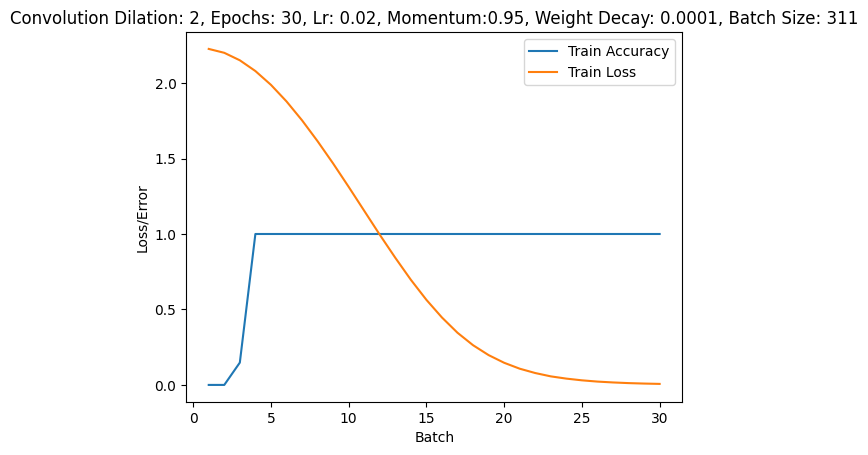

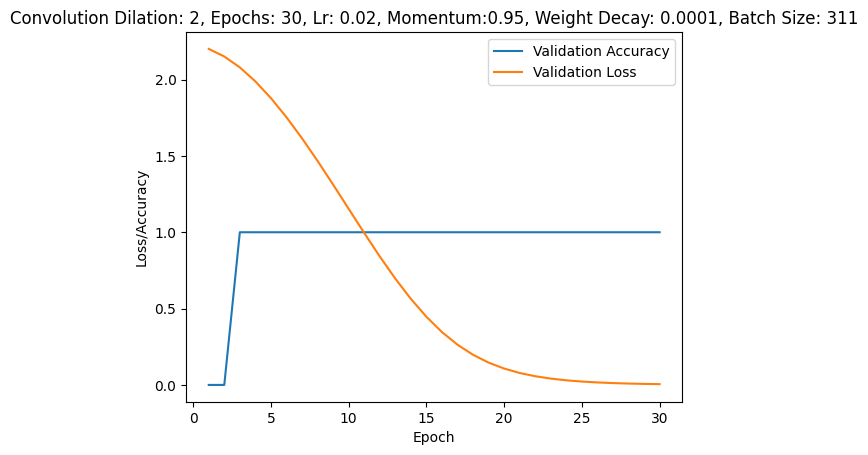

In [111]:
plot_train_curves(loss_dict)
plot_val_curves(loss_dict)

My first experiment is changing the convolution dilation parameter to 4, which drastically increases the receptive field since distances between points on the kernel are now doubled. 

In [31]:
trained_network_dilation_change, loss_dict_dilation, _ = training_wrapper(epochs=30, convolution_dilation=4)

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1554, 9]                 --
├─Sequential: 1-1                        [1554, 2, 14, 14]         --
│    └─Conv2d: 2-1                       [1554, 9, 199, 199]       18,261
│    └─Mish: 2-2                         [1554, 9, 199, 199]       --
│    └─AvgPool2d: 2-3                    [1554, 9, 98, 98]         --
│    └─Mish: 2-4                         [1554, 9, 98, 98]         --
│    └─Conv2d: 2-5                       [1554, 4, 90, 90]         328
│    └─Mish: 2-6                         [1554, 4, 90, 90]         --
│    └─MaxPool2d: 2-7                    [1554, 4, 30, 30]         --
│    └─Mish: 2-8                         [1554, 4, 30, 30]         --
│    └─Conv2d: 2-9                       [1554, 2, 29, 29]         34
│    └─Mish: 2-10                        [1554, 2, 29, 29]         --
│    └─AvgPool2d: 2-11                   [1554, 2, 14, 14]         --
│    └─Mis

Train epochs: 100%|██████████| 30/30 [01:32<00:00,  3.09s/epoch, epoch_loss=0.00671, train_acc=1, train_correct=1554.0, train_total=1554.0, val_acc=1, val_loss=0.00507]


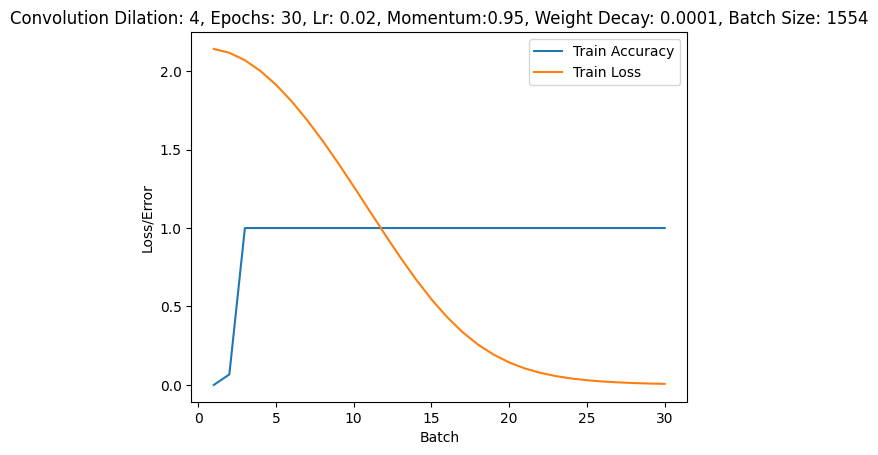

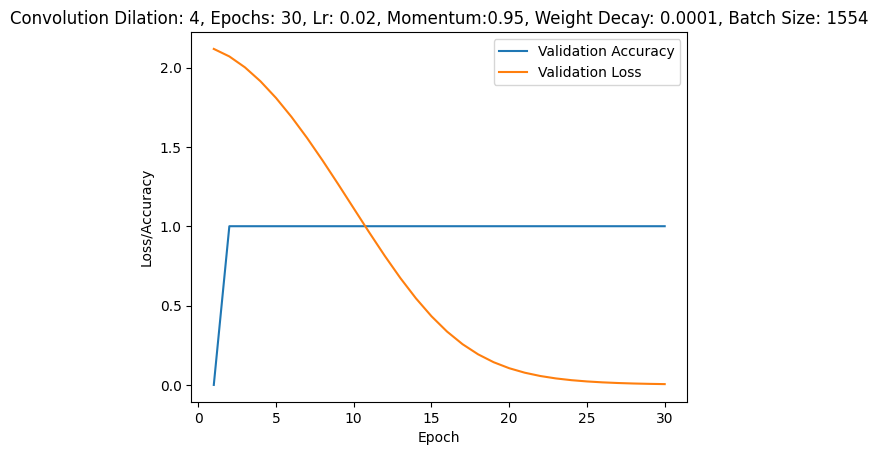

In [32]:
plot_train_curves(loss_dict_dilation)
plot_val_curves(loss_dict_dilation)

My second experiment is the learning rate. Since the model converges to perfect accuracy on both the train and validation sets long before the 30 epochs, we can tune the learning rate to be a bit higher. We do not seem to need to take as small steps towards minima. 

In [33]:
trained_network_lr_change, loss_dict_lr, _ = training_wrapper(epochs=30, learning_rate=0.2)

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1554, 9]                 --
├─Sequential: 1-1                        [1554, 2, 15, 15]         --
│    └─Conv2d: 2-1                       [1554, 9, 199, 199]       18,261
│    └─Mish: 2-2                         [1554, 9, 199, 199]       --
│    └─AvgPool2d: 2-3                    [1554, 9, 98, 98]         --
│    └─Mish: 2-4                         [1554, 9, 98, 98]         --
│    └─Conv2d: 2-5                       [1554, 4, 94, 94]         328
│    └─Mish: 2-6                         [1554, 4, 94, 94]         --
│    └─MaxPool2d: 2-7                    [1554, 4, 31, 31]         --
│    └─Mish: 2-8                         [1554, 4, 31, 31]         --
│    └─Conv2d: 2-9                       [1554, 2, 30, 30]         34
│    └─Mish: 2-10                        [1554, 2, 30, 30]         --
│    └─AvgPool2d: 2-11                   [1554, 2, 15, 15]         --
│    └─Mis

Train epochs: 100%|██████████| 30/30 [01:31<00:00,  3.04s/epoch, epoch_loss=0, train_acc=1, train_correct=1554.0, train_total=1554.0, val_acc=1, val_loss=0]            


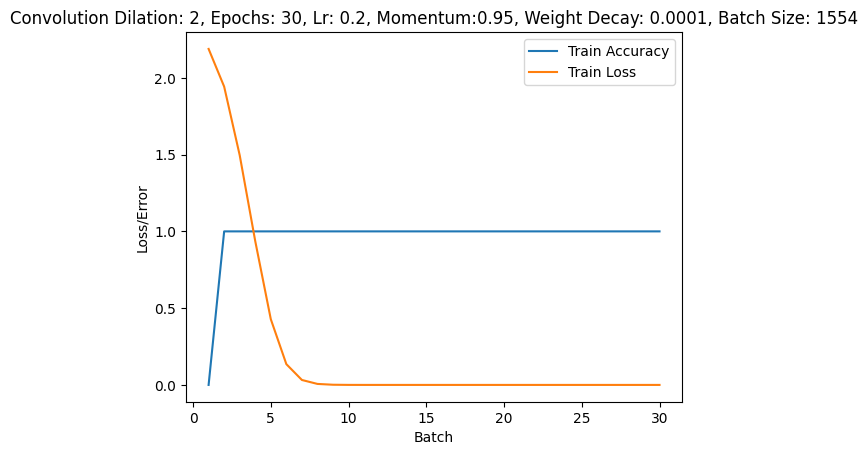

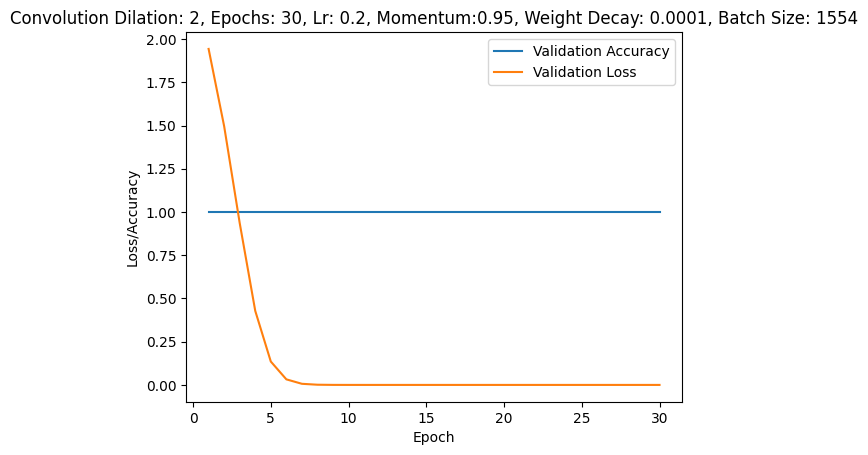

In [34]:
plot_train_curves(loss_dict_lr)
plot_val_curves(loss_dict_lr)

My third experiment is increasing the weight decay parameter since this could help us in finding a set of parameters for the model that corresponding to a well regularized model, which could help us mitigate possibly biases (e.g., inductive biases in making the model).

In [35]:
trained_network_wd_change, loss_dict_wd, _ = training_wrapper(epochs=30, wd=0.01)

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1554, 9]                 --
├─Sequential: 1-1                        [1554, 2, 15, 15]         --
│    └─Conv2d: 2-1                       [1554, 9, 199, 199]       18,261
│    └─Mish: 2-2                         [1554, 9, 199, 199]       --
│    └─AvgPool2d: 2-3                    [1554, 9, 98, 98]         --
│    └─Mish: 2-4                         [1554, 9, 98, 98]         --
│    └─Conv2d: 2-5                       [1554, 4, 94, 94]         328
│    └─Mish: 2-6                         [1554, 4, 94, 94]         --
│    └─MaxPool2d: 2-7                    [1554, 4, 31, 31]         --
│    └─Mish: 2-8                         [1554, 4, 31, 31]         --
│    └─Conv2d: 2-9                       [1554, 2, 30, 30]         34
│    └─Mish: 2-10                        [1554, 2, 30, 30]         --
│    └─AvgPool2d: 2-11                   [1554, 2, 15, 15]         --
│    └─Mis

Train epochs: 100%|██████████| 30/30 [01:29<00:00,  2.99s/epoch, epoch_loss=0.00881, train_acc=1, train_correct=1554.0, train_total=1554.0, val_acc=1, val_loss=0.00687]


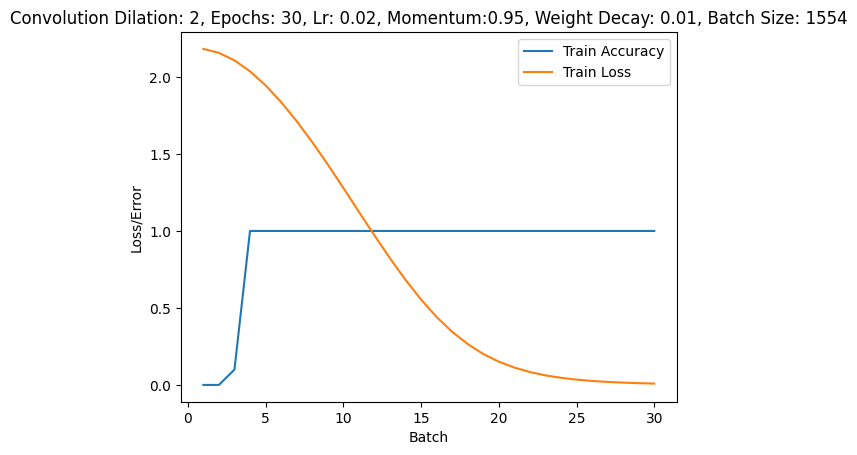

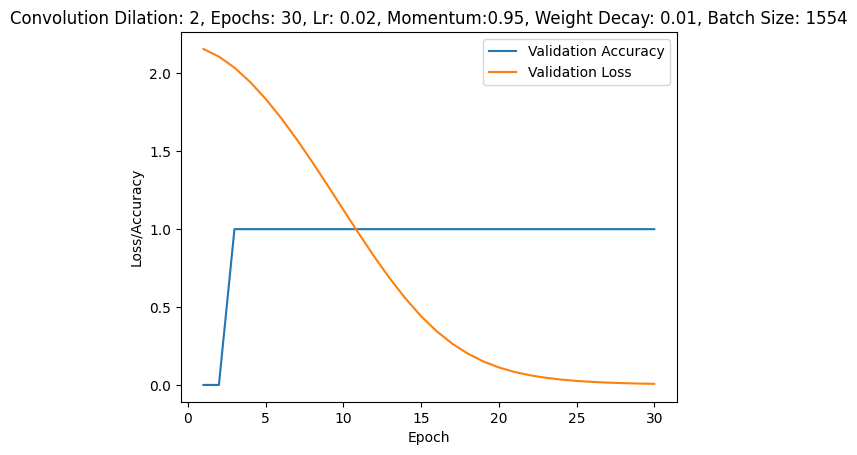

In [36]:
plot_train_curves(loss_dict_wd)
plot_val_curves(loss_dict_wd)

Finally, I will change the batch size to a much smaller batch size and combine all of these changes. Smaller batch sizes can help avoid overfitting as their gradients are computed from randomly sampled minibatches, and so the optimizer steps will be less homogenous and can therefore help explore the loss surface more. 

In [37]:
trained_network_all_change, loss_dict_all, _ = training_wrapper(epochs=30, wd=0.01, batch_size=64, learning_rate=0.008, convolution_dilation=4)

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [64, 9]                   --
├─Sequential: 1-1                        [64, 2, 14, 14]           --
│    └─Conv2d: 2-1                       [64, 9, 199, 199]         18,261
│    └─Mish: 2-2                         [64, 9, 199, 199]         --
│    └─AvgPool2d: 2-3                    [64, 9, 98, 98]           --
│    └─Mish: 2-4                         [64, 9, 98, 98]           --
│    └─Conv2d: 2-5                       [64, 4, 90, 90]           328
│    └─Mish: 2-6                         [64, 4, 90, 90]           --
│    └─MaxPool2d: 2-7                    [64, 4, 30, 30]           --
│    └─Mish: 2-8                         [64, 4, 30, 30]           --
│    └─Conv2d: 2-9                       [64, 2, 29, 29]           34
│    └─Mish: 2-10                        [64, 2, 29, 29]           --
│    └─AvgPool2d: 2-11                   [64, 2, 14, 14]           --
│    └─Mis

Train epochs: 100%|██████████| 30/30 [01:19<00:00,  2.66s/epoch, epoch_loss=0.272, train_acc=1, train_correct=1554.0, train_total=1554.0, val_acc=1, val_loss=0.0106] 


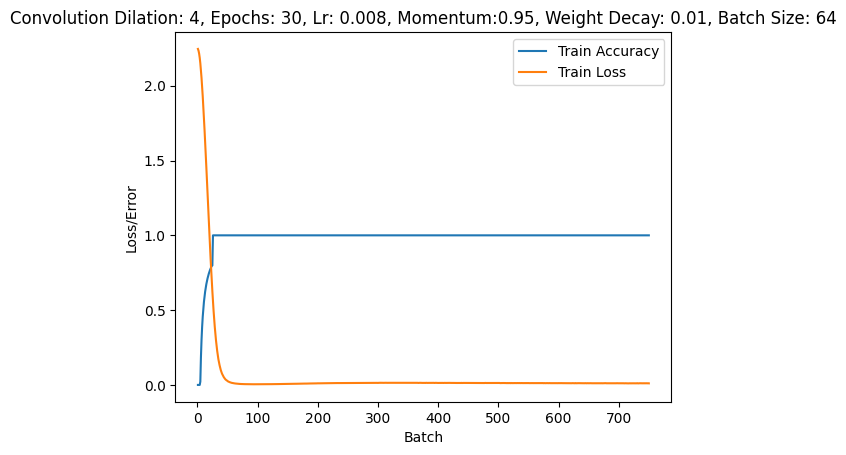

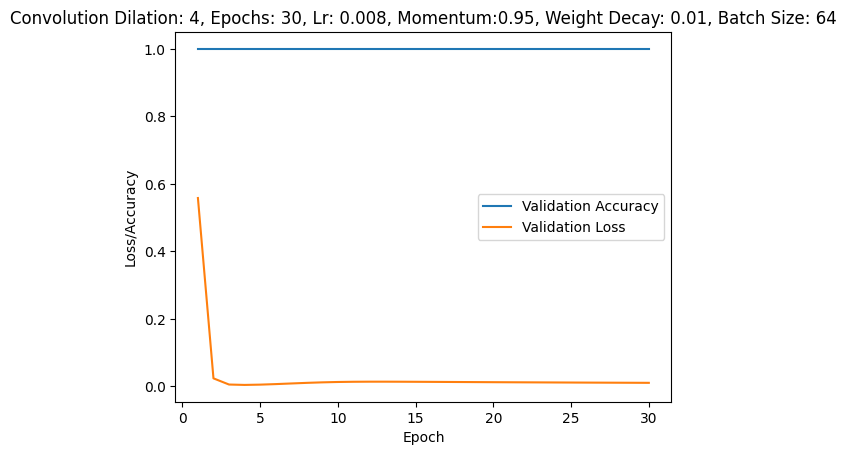

In [38]:
plot_train_curves(loss_dict_all)
plot_val_curves(loss_dict_all)

### Part (c) - 2 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

I choose my best model to be the combined model that has changes to all of the tested hyperparameters. While all of the models have perfect training and validation accuracy, this model used a smaller minibatch size, meaning that it was able to get more hetergeneous estimates of the true gradient. As such, it likely explored the loss surface more, and perhaps it has a more reliable set of parameters. In particular, large minibatch sizes (> 512) appear to converge to sharp minima according to [Keskar et al.](https://arxiv.org/pdf/1609.04836.pdf), which lead to worse generalization performance.

### Part (d) - 2 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [42]:
train_set, val_set, test_set = create_datasets()
split_sets = (train_set, val_set, test_set)

_, _, test_loader = create_dataloaders(
    split_sets, batch_size=64, use_cuda=True)
test_acc, test_correct, test_total, test_loss = compute_test_performance(trained_network_all_change, test_loader)
print(test_acc, test_loss)

1.0 0.010579031892120838


The test accuracy is 100%, so the model was able to perfectly classify all of the hand signs as it did with the training and validation sets! 

### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [2]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)
alexnet = alexnet.to(device="cuda:0")

c:\ProgramData\Anaconda3\envs\pytorch-latest\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\pytorch-latest\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [65]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
train_set, val_set, test_set = create_datasets()
split_sets = (train_set, val_set, test_set)
train_loader, val_loader, test_loader = create_dataloaders(split_sets, batch_size=len(train_set))
train_embeds, val_embeds, test_embeds = None, None, None
train_targets, val_targets, test_targets = None, None, None
for i, batch in enumerate(train_loader):
    input, targets = batch
    input = input.to("cuda:0")
    targets = targets.to("cuda:0")
    train_embeds = alexnet.features(input)
    train_targets = targets
for i, batch in enumerate(val_loader):
    input, targets = batch
    input = input.to("cuda:0")
    targets = targets.to("cuda:0")
    val_embeds = alexnet.features(input)
    val_targets = targets
for i, batch in enumerate(test_loader):
    input, targets = batch
    input = input.to("cuda:0")
    targets = targets.to("cuda:0")
    test_embeds = alexnet.features(input)
    test_targets = targets

In [74]:
train_embeds.size(), val_embeds.size(), test_embeds.size()

(torch.Size([1554, 256, 6, 6]),
 torch.Size([222, 256, 6, 6]),
 torch.Size([443, 256, 6, 6]))

In [68]:
torch.save(train_embeds, "./train_embeds")
torch.save(val_embeds, "./val_embeds")
torch.save(test_embeds, "./test_embeds")

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [79]:
class TransferCNN(nn.Module):
    def __init__(self, conv_dilation=2):
        super().__init__()
        self.feature_embeddings = nn.Sequential(
            nn.Conv2d(256, 128, 2, dilation=conv_dilation),
            nn.Mish(inplace=True),
            nn.Conv2d(128, 64, 2),
            nn.Mish(inplace=True))
        # programmatically get feature embedding size 
        self._feature_embed_size = list(self.feature_embeddings(torch.rand(1, 256, 6, 6)).detach().size())
        self.embedding_size = np.prod(self._feature_embed_size)
        # use dropout to regularize model 
        self.dropout = nn.Dropout(p=0.05)
        self.flatten = nn.Flatten()

        # autoencoder like architecture - just remove reconstruction layers
        self.fc1 = nn.Linear(self.embedding_size, self.embedding_size//2)
        self.act1 = nn.Mish()
        self.fc2 = nn.Linear(self.embedding_size//2, self.embedding_size//4)
        self.act2 = nn.Mish()
        self.fc3 = nn.Linear(self.embedding_size//4, self.embedding_size//4)
        self.act3 = nn.Mish()
        self.fc4 = nn.Linear(self.embedding_size//4, self.embedding_size//2)
        self.act4 = nn.Mish()
        self.fc5 = nn.Linear(self.embedding_size//2, 9)

    def forward(self, input):
        # create latent space rep.
        z = self.flatten(self.feature_embeddings(input))
        z = self.act1(self.fc1(z))
        z = self.dropout(z)
        z = self.act2(self.fc2(z))
        z = self.dropout(z)
        z = self.act3(self.fc3(z))
        z = self.dropout(z)
        z = self.act4(self.fc4(z))
        z = self.dropout(z)
        out = self.fc5(z)
        return out

In [80]:
model = TransferCNN().to("cuda:0")
summary(model, (1, 256, 6, 6), verbose=1)

Layer (type:depth-idx)                   Output Shape              Param #
TransferCNN                              [1, 9]                    --
├─Sequential: 1-1                        [1, 64, 3, 3]             --
│    └─Conv2d: 2-1                       [1, 128, 4, 4]            131,200
│    └─Mish: 2-2                         [1, 128, 4, 4]            --
│    └─Conv2d: 2-3                       [1, 64, 3, 3]             32,832
│    └─Mish: 2-4                         [1, 64, 3, 3]             --
├─Flatten: 1-2                           [1, 576]                  --
├─Linear: 1-3                            [1, 288]                  166,176
├─Mish: 1-4                              [1, 288]                  --
├─Dropout: 1-5                           [1, 288]                  --
├─Linear: 1-6                            [1, 144]                  41,616
├─Mish: 1-7                              [1, 144]                  --
├─Dropout: 1-8                           [1, 144]                  

Layer (type:depth-idx)                   Output Shape              Param #
TransferCNN                              [1, 9]                    --
├─Sequential: 1-1                        [1, 64, 3, 3]             --
│    └─Conv2d: 2-1                       [1, 128, 4, 4]            131,200
│    └─Mish: 2-2                         [1, 128, 4, 4]            --
│    └─Conv2d: 2-3                       [1, 64, 3, 3]             32,832
│    └─Mish: 2-4                         [1, 64, 3, 3]             --
├─Flatten: 1-2                           [1, 576]                  --
├─Linear: 1-3                            [1, 288]                  166,176
├─Mish: 1-4                              [1, 288]                  --
├─Dropout: 1-5                           [1, 288]                  --
├─Linear: 1-6                            [1, 144]                  41,616
├─Mish: 1-7                              [1, 144]                  --
├─Dropout: 1-8                           [1, 144]                  

In [81]:
model.eval()
output = model(train_embeds)
prob = F.softmax(output)
torch.max(prob, 1)[1].detach()

C:\Users\ericz\AppData\Local\Temp\ipykernel_16976\3956553545.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = F.softmax(output)


tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [87]:
def compute_loss(preds, targets):
    criterion = nn.CrossEntropyLoss()
    return criterion(preds, targets)


def transfer_train_loop(train_data, val_data, convolution_dilation=2, epochs=1000, learning_rate=0.02, momentum=0.95, wd=1e-4, batch_size=None, use_cuda=True):
    if use_cuda and torch.cuda.is_available():
        dev = "cuda:0"
    else:
        print("CUDA unavailable, training on CPU")
        dev = "CPU"
    device = torch.device(dev)

    network = TransferCNN(conv_dilation=convolution_dilation)
    network = network.to(device)
    optimizer = torch.optim.SGD(network.parameters(
    ), lr=learning_rate, momentum=momentum, weight_decay=wd)

    if train_data is not None:
        summary(network, input_data=train_data[0], verbose=1, device=device)

    loss_dict = {"config": f"Convolution Dilation: {convolution_dilation}, Epochs: {epochs}, Lr: {learning_rate}, Momentum:{momentum}, Weight Decay: {wd}, Batch Size: {batch_size}",
                 "train_loss": [], "val_loss": [],
                 "train_acc": [], "val_acc": []}

    with trange(epochs, desc="Train epochs", unit="epoch") as train_bar:
        for epoch in train_bar:
            epoch_loss, val_loss = 0.0, 0.0
            train_correct, train_total = 0.0, 0.0
            val_correct, val_total = 0.0, 0.0
            
            # reenable train mode to enable dropout
            network.train()
            inputs, targets = train_data
            inputs = inputs.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)

            network.zero_grad()

            preds = network(inputs)
            loss = compute_loss(preds, targets)

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                # eval mode to disable dropout
                network.eval()
                epoch_loss += loss.item()
                _, category_preds = torch.max(preds, 1)
                train_correct += float((category_preds ==
                                        targets).sum().item())
                train_total += float(len(preds))
                loss_dict["train_loss"].append(loss.item())
                loss_dict["train_acc"].append(train_correct/train_total)

                inputs, targets = val_data
                inputs = inputs.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)

                preds = network(inputs)
                batch_val_loss = compute_loss(preds, targets).item()
                val_loss += batch_val_loss
                _, category_preds = torch.max(preds, 1)
                val_correct += float((category_preds ==
                                        targets).sum().item())
                val_total += float(len(preds))
                loss_dict["val_loss"].append(batch_val_loss)
                loss_dict["val_acc"].append(val_correct/val_total)

            train_bar.set_postfix(epoch_loss=epoch_loss,
                                  train_acc=train_correct/train_total,
                                  train_correct=train_correct,
                                  train_total=train_total,
                                  val_loss=val_loss,
                                  val_acc=val_correct/val_total)
    return network, loss_dict


def compute_transfer_test_performance(network, test_data):
    test_correct, test_total = 0.0, 0.0
    test_loss = 0.0

    device = next(network.parameters()).device
    with torch.no_grad():
        # disable dropout for test time
        network.eval()
        inputs, targets = test_data
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        preds = network(inputs)
        test_loss += compute_loss(preds, targets).item()
        _, category_preds = torch.max(preds, 1)
        test_correct += float((category_preds == targets).sum().item())
        test_total += len(preds)
    return test_correct/test_total, test_correct, test_total, test_loss


In [83]:
train_embeds, val_embeds = torch.tensor(train_embeds.detach()), torch.tensor(val_embeds.detach())
transfer_model, loss_dict_transfer = transfer_train_loop((train_embeds, train_targets), (val_embeds, val_targets))

C:\Users\ericz\AppData\Local\Temp\ipykernel_16976\3592352514.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeds, val_embeds = torch.tensor(train_embeds.detach()), torch.tensor(val_embeds.detach())


Layer (type:depth-idx)                   Output Shape              Param #
TransferCNN                              [1554, 9]                 --
├─Sequential: 1-1                        [1554, 64, 3, 3]          --
│    └─Conv2d: 2-1                       [1554, 128, 4, 4]         131,200
│    └─Mish: 2-2                         [1554, 128, 4, 4]         --
│    └─Conv2d: 2-3                       [1554, 64, 3, 3]          32,832
│    └─Mish: 2-4                         [1554, 64, 3, 3]          --
├─Flatten: 1-2                           [1554, 576]               --
├─Linear: 1-3                            [1554, 288]               166,176
├─Mish: 1-4                              [1554, 288]               --
├─Dropout: 1-5                           [1554, 288]               --
├─Linear: 1-6                            [1554, 144]               41,616
├─Mish: 1-7                              [1554, 144]               --
├─Dropout: 1-8                           [1554, 144]               

Train epochs: 100%|██████████| 1000/1000 [00:06<00:00, 143.75epoch/s, epoch_loss=3.84e-10, train_acc=1, train_correct=1554.0, train_total=1554.0, val_acc=1, val_loss=0]    


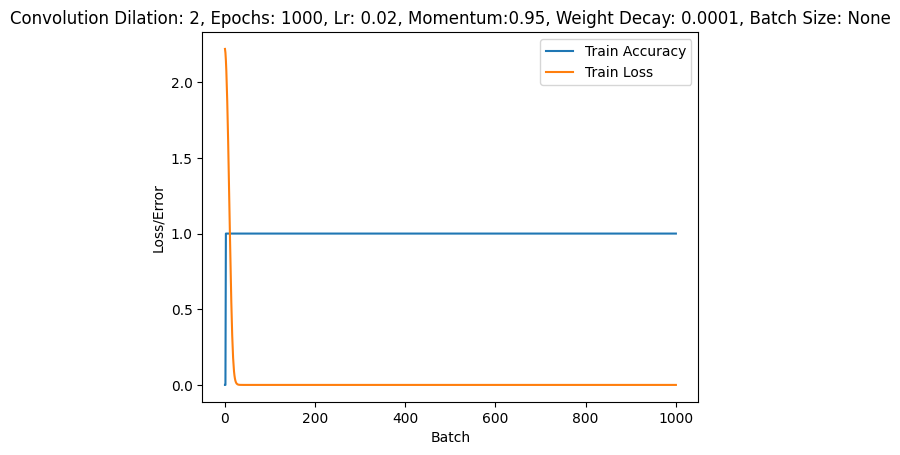

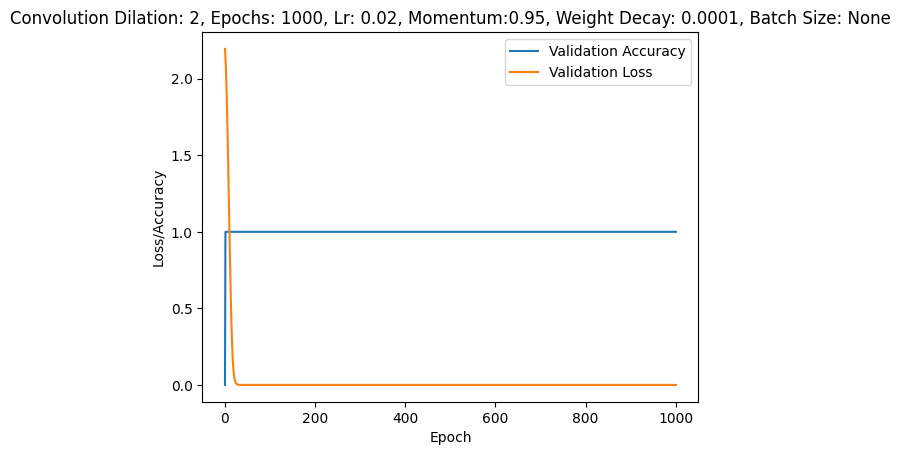

In [86]:
plot_train_curves(loss_dict_transfer)
plot_val_curves(loss_dict_transfer)

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [92]:
test_embeds = torch.tensor(test_embeds.clone().detach())
test_accuracy, _, _, test_loss = compute_transfer_test_performance(transfer_model, (test_embeds, test_targets))
print(test_accuracy, test_loss)

1.0 0.0


C:\Users\ericz\AppData\Local\Temp\ipykernel_16976\940114777.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeds = torch.tensor(test_embeds.clone().detach())


The transfer learning model performed as the model from part 3(d), i.e., both achieved 100% on the test set. So both models did exceptionally well! 

### 5. Additional Testing [5 pt]
As a final step in testing we will be revisiting the sample images that you had collected and submitted at the start of this lab. These sample images should be untouched and will be used to demonstrate how well your model works at identifying your hand guestures. 

Using the best transfer learning model developed in Part 4. Report the test accuracy on your sample images and how it compares to the test accuracy obtained in Part 4(d)? How well did your model do for the different hand guestures? Provide an explanation for why you think your model performed the way it did?